# 动画

动画说白了就是隔段时间刷新一下画面,`matplotlib.animation`提供了构建动画的工具主要是这几个方法:

+ 通过函数构建
+ 通过作品构建
+ 通过继承`matplotlib.animation.TimedAnimation`类制作动画

动画需要后渲染后端,一般使用[ffmpeg](http://ffmpeg.zeranoe.com/builds/),安装方法可以看[]这里](http://www.wikihow.com/Install-FFmpeg-on-Windows)

无论哪种方式构建的动画都可以通过`.save`方法保存为希望的格式,也可以用`.to_html5_video`方法输出一份html5可以读取的文件.

In [1]:
from __future__ import print_function
from imp import reload
import matplotlib
reload(matplotlib)

matplotlib.use('nbagg')

import matplotlib.backends.backend_nbagg
reload(matplotlib.backends.backend_nbagg)
import matplotlib.backends.backend_webagg_core
reload(matplotlib.backends.backend_webagg_core)

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

plt.interactive(False)

## 通过函数构建动画

`matplotlib.animation.FuncAnimation(fig, func, frames=None, init_func=None, fargs=None, save_count=None, **kwargs)`

FuncAnimation类是最常用的构建函数.

他的构造函数有这样一些参数

+ fig 一个figure对象,图像都是基于这个对象相当于一个画板
+ func(frame)->tuple(axes.plot) 一个构建动画函数,参数是frames传入的每一帧,而返回的是一个由参数构建的plot对象构成的tuple
+ frames 一个可迭代对象,可以是生成器,可以是一个序列,也可以是数字,数字相当于传入一个xrange(n)
+ init_func(frame)->tuple(axes.plot) 初始化函数,第0帧时候调用它构建图形
+ 如果blit = True，func和init_func必须返回一个可迭代的作品对象来重绘
+ kwargs包括repeat，repeat_delay和interval：
    + interval每隔interval毫秒绘制一个新帧。
    + repeat控制动画是否应在帧序列完成时重复。 
    + repeat_delay可选地在重复动画之前添加以毫秒为单位的延迟。



In [2]:
from IPython.display import HTML

In [3]:
%matplotlib inline

In [4]:
plt.style.use("animation_support")

### 使用数字定义帧

RuntimeError: No MovieWriters available!

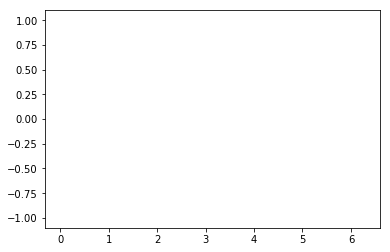

In [5]:
fig, ax = plt.subplots()

x = np.arange(0, 2*np.pi, 0.01)
line, = ax.plot(x, np.sin(x))


def animate(i):
    line.set_ydata(np.sin(x + i/10.0))  # update the data
    return line,


# Init only required for blitting to give a clean slate.
def init():
    line.set_ydata(np.ma.array(x, mask=True))
    return line,

ani = animation.FuncAnimation(fig, animate, 200, init_func=init,
                              interval=25, blit=True)

ani

### 使用生成器定义帧

In [8]:
# 使用生成器构建每一帧的传入数据
def data_gen(t=0):
    cnt = 0
    while cnt < 1000:
        cnt += 1
        t += 0.1
        yield t, np.sin(2*np.pi*t) * np.exp(-t/10.)



# 全局变量组,
fig, ax = plt.subplots()
line, = ax.plot([], [], lw=2) # 关键部分,刷新的就是它
ax.grid()
xdata, ydata = [], []

# 第一帧的内容
def init():
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(0, 10)
    del xdata[:]
    del ydata[:]
    line.set_data(xdata, ydata)
    return line,

# 刷新图片的函数
def run(data):
    t, y = data
    xdata.append(t)
    ydata.append(y)
    xmin, xmax = ax.get_xlim()

    if t >= xmax:
        ax.set_xlim(xmin, 2*xmax)
        ax.figure.canvas.draw()
    line.set_data(xdata, ydata)

    return line,

ani = animation.FuncAnimation(fig, run, data_gen, blit=False, interval=10,
                              repeat=False, init_func=init)
ani

## 通过作品组合构建动画

`matplotlib.animation.ArtistAnimation(fig, artists, *args, **kwargs)`

这种方式和上面类似,只是先画好每一幅图,之后按顺序和指定的帧率制作动画

In [10]:
fig2 = plt.figure()

x = np.arange(-9, 10)
y = np.arange(-9, 10).reshape(-1, 1)
base = np.hypot(x, y)
ims = []
for add in np.arange(15):
    ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

im_ani = animation.ArtistAnimation(fig2, ims, interval=50, repeat_delay=3000,
                                   blit=True)
im_ani

## 通过继承构建

`matplotlib.animation.TimedAnimation`是上面俩的基类,我们也可以直接继承它来构造动画,主要要重载的是
+ `__init__()`方法
+ `_draw_frame`方法,对应func
+ `new_frame_seq`对应frames
+ `_init_draw`对应init_func

In [12]:
from matplotlib.lines import Line2D
class SubplotAnimation(animation.TimedAnimation):
    def __init__(self):
        fig = plt.figure()
        ax1 = fig.add_subplot(1, 2, 1)
        ax2 = fig.add_subplot(2, 2, 2)
        ax3 = fig.add_subplot(2, 2, 4)

        self.t = np.linspace(0, 80, 400)
        self.x = np.cos(2 * np.pi * self.t / 10.)
        self.y = np.sin(2 * np.pi * self.t / 10.)
        self.z = 10 * self.t

        ax1.set_xlabel('x')
        ax1.set_ylabel('y')
        self.line1 = Line2D([], [], color='black')
        self.line1a = Line2D([], [], color='red', linewidth=2)
        self.line1e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax1.add_line(self.line1)
        ax1.add_line(self.line1a)
        ax1.add_line(self.line1e)
        ax1.set_xlim(-1, 1)
        ax1.set_ylim(-2, 2)
        ax1.set_aspect('equal', 'datalim')

        ax2.set_xlabel('y')
        ax2.set_ylabel('z')
        self.line2 = Line2D([], [], color='black')
        self.line2a = Line2D([], [], color='red', linewidth=2)
        self.line2e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax2.add_line(self.line2)
        ax2.add_line(self.line2a)
        ax2.add_line(self.line2e)
        ax2.set_xlim(-1, 1)
        ax2.set_ylim(0, 800)

        ax3.set_xlabel('x')
        ax3.set_ylabel('z')
        self.line3 = Line2D([], [], color='black')
        self.line3a = Line2D([], [], color='red', linewidth=2)
        self.line3e = Line2D(
            [], [], color='red', marker='o', markeredgecolor='r')
        ax3.add_line(self.line3)
        ax3.add_line(self.line3a)
        ax3.add_line(self.line3e)
        ax3.set_xlim(-1, 1)
        ax3.set_ylim(0, 800)

        animation.TimedAnimation.__init__(self, fig, interval=50, blit=True)

    def _draw_frame(self, framedata):
        i = framedata
        head = i - 1
        head_len = 10
        head_slice = (self.t > self.t[i] - 1.0) & (self.t < self.t[i])

        self.line1.set_data(self.x[:i], self.y[:i])
        self.line1a.set_data(self.x[head_slice], self.y[head_slice])
        self.line1e.set_data(self.x[head], self.y[head])

        self.line2.set_data(self.y[:i], self.z[:i])
        self.line2a.set_data(self.y[head_slice], self.z[head_slice])
        self.line2e.set_data(self.y[head], self.z[head])

        self.line3.set_data(self.x[:i], self.z[:i])
        self.line3a.set_data(self.x[head_slice], self.z[head_slice])
        self.line3e.set_data(self.x[head], self.z[head])

        self._drawn_artists = [self.line1, self.line1a, self.line1e,
                               self.line2, self.line2a, self.line2e,
                               self.line3, self.line3a, self.line3e]

    def new_frame_seq(self):
        return iter(range(self.t.size))

    def _init_draw(self):
        lines = [self.line1, self.line1a, self.line1e,
                 self.line2, self.line2a, self.line2e,
                 self.line3, self.line3a, self.line3e]
        for l in lines:
            l.set_data([], [])

In [13]:
ani = SubplotAnimation()
ani

## 动画的输出

最简单的输出就是直接通过matplotlib输出,直接`plt.show()`即可,注意这种方式jupyter notebook并不支持.只能在脚本中使用

### 输出为html5可读的视屏

使用`.to_html5_video()`方法可以直接输出一段浏览器可以识别的带标签的html5字符串这种可以直接嵌入到网页前端

### 保存动画

动画保存是通过`.save(filename, writer=None, fps=None, dpi=None, codec=None, bitrate=None, extra_args=None, metadata=None, extra_anim=None, savefig_kwargs=None)`方法

+ writer可以自己定义转码工具,默认为ffmpeg
+ fps为帧率
+ dpi控制动画每帧中的每英寸点数.
+ codec指定保存的格式,默认使用filename的后缀作为格式
+ bitrate指定压缩影片每秒使用的位数，以千位/秒为单位。更高的数字意味着更高质量的电影，但是以增加的文件大小为代价。如果未指定值，则默认值为rcparam animation.bitrate给出的值。
+ metadata元数据包括在输出文件中的元数据的键和值的字典。可能有用的一些键包括：标题，艺术家，流派，主题，版权，srcform，注释。

### 动画生成和转码工具的设置

matplotlib本身就是个作图的工具,本身无法制作动画,但他可以通过其他工具提供了几个参数用来转码和设置,我们可以定义一个主题来实现需要的时候加载

```
animation.ffmpeg_path : <yourpathtoffmpeg>/bin/ffmpeg
animation.convert_path: <yourpathtoimagemagick>/imagemagick/6.9.7-0/bin/convert
animation.html: html5
```

通过这样的设置可以使用ffmpeg工具转码为常见的格式如MP4,也可以通过指定writer参数来使用imagemagick构建gif动画图片.

第三个参数是为了让jupyter notebook可以直接显示动画,如果不设置也可以使用

`from IPython.display import HTML`

然后`HTML(ani.to_html5())`来输出动画